In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [26]:
temp = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv')
temp = temp[:365]

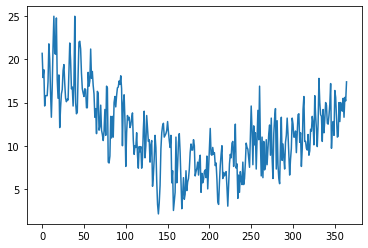

In [27]:
plt.plot(temp.Temp)

In [28]:
temp.Temp[:10].mean(),temp.Temp[:10].std()

(17.86, 2.4180800464647794)

In [29]:
temp.Temp[10:20].mean(),temp.Temp[10:20].std()

(19.2, 3.9510898637098992)

In [30]:
temp.Temp[20:30].mean(),temp.Temp[20:30].std()

(16.309999999999995, 2.1921323966504493)

In [31]:
temp.Temp[300:310].mean(),temp.Temp[300:310].std()

(11.610000000000001, 1.3811830677599064)

In [32]:
#raw
from statsmodels.tsa.stattools import adfuller
adfuller(temp.Temp)

(-2.4549518801166093,
 0.12682316388801884,
 6,
 358,
 {'1%': -3.448748905151901,
  '5%': -2.8696473721448728,
  '10%': -2.5710891239349585},
 1607.4780885337195)

In [33]:
#Agumented Dicky Fuller's Test
#used for checking stationarity

# Null Hypothesis: It is non stationary
# Alternate Hypothesis: It is stationary

def adfuller_test(val):
    
    result = adfuller(val)
    
    labels = ['ADF Test Statistic','p-value','Lags','Number of Observations Used']
    
    for value,label in zip(result,labels):
        
        print(label+' : '+str(value))
        
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis.Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")


adfuller_test(temp.Temp)

ADF Test Statistic : -2.4549518801166093
p-value : 0.12682316388801884
Lags : 6
Number of Observations Used : 358
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [34]:
#Differencing
temp['1st Differencing'] = temp.Temp - temp.Temp.shift(1)
temp

,Date,Temp,1st Differencing
0,1981-01-01,20.7,NaN
1,1981-01-02,17.9,-2.8
2,1981-01-03,18.8,0.9
3,1981-01-04,14.6,-4.2
4,1981-01-05,15.8,1.2
...,...,...,...
360,1981-12-27,15.5,1.5
361,1981-12-28,13.3,-2.2
362,1981-12-29,15.6,2.3
363,1981-12-30,15.2,-0.4


In [35]:
adfuller_test(temp['1st Differencing'].dropna())

ADF Test Statistic : -7.558332159146303
p-value : 3.0570328858541614e-11
Lags : 17
Number of Observations Used : 346
strong evidence against the null hypothesis, reject the null hypothesis.Data has no unit root and is stationary


In [12]:
#Differencing
temp['2nd Differencing'] = temp['1st Differencing'] - temp['1st Differencing'].shift(1)
adfuller_test(temp['2nd Differencing'].dropna())

ADF Test Statistic : -8.830005396162226
p-value : 1.780373069387797e-14
Lags : 17
Number of Observations Used : 345
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


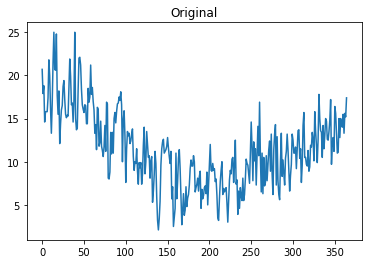

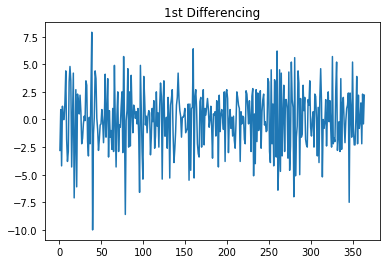

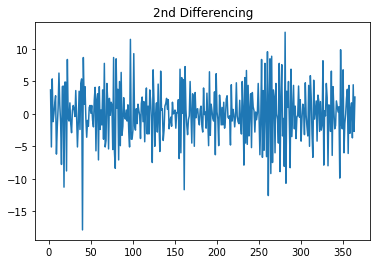

In [13]:
plt.plot(temp.Temp)
plt.title('Original')
plt.show()

plt.plot(temp['1st Differencing'].dropna())
plt.title('1st Differencing')
plt.show()

plt.plot(temp['2nd Differencing'].dropna())
plt.title('2nd Differencing')
plt.show()

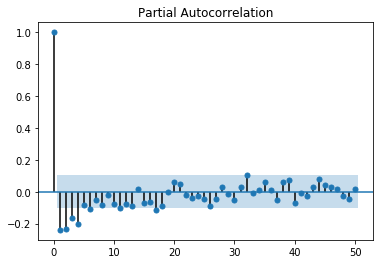

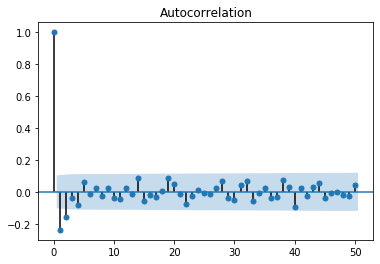

In [15]:
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
plot_pacf(temp['1st Differencing'].dropna(), lags=50)
plot_acf(temp['1st Differencing'].dropna(), lags=50)
plt.show()

In [14]:
from statsmodels.tsa.arima_model import ARMA
from sklearn.metrics import mean_squared_error,mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

X = temp.Temp
train = temp['1st Differencing'][1:350]
test  = temp['1st Differencing'][350:]

df_perf = []
for i in range(5):
    for j in range(3):
        model = ARMA(train.dropna(), order=(i, j)).fit()
        preds = model.predict(349,363)
        df_perf.append([i,j,mean_squared_error(test, preds),mean_absolute_error(test, preds)])
        
pd.DataFrame(df_perf,columns = ['AR (p)','MA (q)','MSE','MAE'])

,AR (p),MA (q),MSE,MAE
0,0,0,5.437910,1.904852
1,0,1,4.955116,1.856203
2,0,2,4.902328,1.877830
3,1,0,5.183909,1.875577
4,1,1,5.075613,1.892268
5,1,2,5.092099,1.898764
6,2,0,5.223898,1.890301
7,2,1,5.090626,1.898478
8,2,2,4.993442,1.875571
9,3,0,5.539479,1.939041


In [17]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:       1st Differencing   No. Observations:                  349
Model:                     ARMA(4, 2)   Log Likelihood                -804.974
Method:                       css-mle   S.D. of innovations              2.426
Date:                Sat, 25 Apr 2020   AIC                           1625.948
Time:                        14:01:35   BIC                           1656.788
Sample:                             0   HQIC                          1638.225
                                                                              
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0.0163      0.020     -0.818      0.414      -0.055       0.023
ar.L1.1st Differencing    -0.2782      0.257     -1.080      0.281      -0.783       0.227
ar.L2.1st Differencing     0.3030      0.139      2.185      0.030       0.031       0.575
ar.L3.1st Differencing    -0.0082      0.064     -0.128      0.898      -0.134       0.117
ar.L4.1st Differencing    -0.0259      0.061     -0.425      0.671      -0.145       0.093
ma.L1.1st Differencing    -0.1598      0.253     -0.633      0.527      -0.655       0.335
ma.L2.1st Differencing    -0.6902      0.234     -2.947      0.003      -1.149      -0.231
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.3843           -1.2162j            2.6766           -0.0751
AR.2            2.3843           +1.2162j            2.6766            0.0751
AR.3           -1.5050           -0.0000j            1.5050           -0.5000
AR.4           -3.5798           -0.0000j            3.5798           -0.5000
MA.1            1.0934           +0.0000j            1.0934            0.0000
MA.2           -1.3250           +0.0000j            1.3250            0.5000
-----------------------------------------------------------------------------
"""

In [15]:
model = ARMA(train.dropna(), order=(4, 0)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:       1st Differencing   No. Observations:                  349
Model:                     ARMA(4, 0)   Log Likelihood                -816.142
Method:                       css-mle   S.D. of innovations              2.507
Date:                Sat, 20 Feb 2021   AIC                           1644.284
Time:                        01:22:21   BIC                           1667.414
Sample:                             0   HQIC                          1653.491
                                                                              
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0.0197      0.064     -0.309      0.757      -0.145       0.105
ar.L1.1st Differencing    -0.3604      0.053     -6.841      0.000      -0.464      -0.257
ar.L2.1st Differencing    -0.3358      0.055     -6.138      0.000      -0.443      -0.229
ar.L3.1st Differencing    -0.2248      0.055     -4.106      0.000      -0.332      -0.118
ar.L4.1st Differencing    -0.1913      0.053     -3.599      0.000      -0.296      -0.087
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.5986           -1.3079j            1.4384           -0.1817
AR.2            0.5986           +1.3079j            1.4384            0.1817
AR.3           -1.1861           -1.0579j            1.5893           -0.3841
AR.4           -1.1861           +1.0579j            1.5893            0.3841
-----------------------------------------------------------------------------
"""

In [16]:
model = ARMA(train.dropna(), order=(0, 2)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:       1st Differencing   No. Observations:                  349
Model:                     ARMA(0, 2)   Log Likelihood                -808.451
Method:                       css-mle   S.D. of innovations              2.450
Date:                Sat, 20 Feb 2021   AIC                           1624.901
Time:                        01:22:23   BIC                           1640.322
Sample:                             0   HQIC                          1631.040
                                                                              
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0.0158      0.024     -0.654      0.513      -0.063       0.032
ma.L1.1st Differencing    -0.4700      0.049     -9.558      0.000      -0.566      -0.374
ma.L2.1st Differencing    -0.3488      0.051     -6.776      0.000      -0.450      -0.248
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.1486           +0.0000j            1.1486            0.0000
MA.2           -2.4961           +0.0000j            2.4961            0.5000
-----------------------------------------------------------------------------
"""

<Figure size 720x720 with 0 Axes>

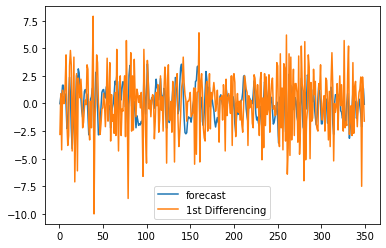

In [20]:
plt.figure(figsize=(10,10))
model.plot_predict()
plt.show()

In [21]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:       1st Differencing   No. Observations:                  349
Model:                     ARMA(0, 2)   Log Likelihood                -808.451
Method:                       css-mle   S.D. of innovations              2.450
Date:                Sat, 20 Feb 2021   AIC                           1624.901
Time:                        01:22:59   BIC                           1640.322
Sample:                             0   HQIC                          1631.040
                                                                              
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0.0158      0.024     -0.654      0.513      -0.063       0.032
ma.L1.1st Differencing    -0.4700      0.049     -9.558      0.000      -0.566      -0.374
ma.L2.1st Differencing    -0.3488      0.051     -6.776      0.000      -0.450      -0.248
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.1486           +0.0000j            1.1486            0.0000
MA.2           -2.4961           +0.0000j            2.4961            0.5000
-----------------------------------------------------------------------------
"""